# Feature Selection for Springflow Prediction
##### By Emily Pease, UT Austin
##### 11/18/2019

The Edwards Aquifer Authority (EAA) and all stakeholders need accurate and current springflow data in order to make informed decisions for Comal Springs, especially during drought periods when the endangered species that inhabit the springs are most at risk due to low water levels \cite{lizards}.  However, springflow is difficult to measure directly due to the complexity of numerous seeps and spring orifices and the intermittent presence of rainfall and runoff.  The U.S. Geological Survey (USGS) is the federal agency responsible for correctly measuring the daily spring discharge and the EAA is responsible for regulating discharge through groundwater pumping or withdrawal to ensure the springs are flowing above drought thresholds.  

The current method used by the USGS for measuring springflow at Comal Springs involves separating the springflow component from the streamflow, otherwise referred to as baseflow separation or hydrograph separation \cite{wahl1995determining}.  This method includes some manual estimation of springflow, making this method's results often subjective and time-consuming.  The USGS often needs up to three months to publicly release springflow estimates, though the EAA and other water resource managers need to make daily water use decisions, especially when the aquifer levels are close to drought stage thresholds.  Additionally, these springs are primarily modeled by the EAA using theory-based models to simulate pumping scenarios and drought scenarios.  Here, a springflow prediction model was created using a theory-guided data science approach as a viable option for water resource management. 


### Methods used for feature ranking here include:
1. Summary statistics
2. Visual inspection of scatter matrices and heat maps
3. Correlation coefficients
4. Model-based (LASSO)
5. Domain expertise

### Dataset Description

When performing statistical learning methods on big data, there is often a precompiled dataset containing all parameters for analysis. Here, there was no master dataset of all Edwards Aquifer data and all data used in this study were individually accessed from their respective agencies and  preprocessed prior to model runs.  The individual features selected to be included in the comprehensive Edwards Aquifer dataset are from the EAA, USGS, and National Oceanic and Atmospheric Administration (NOAA).  The time frame for this study is from 1950-01-01 to present using daily data that captures the two major droughts in recent history (1950-1956, 2011-2014). 

Predictor features:
1. J-17: Bexar County index well, located 24 miles from Comal Springs (EAA)
2. J-27: Uvalde County index well, located 106 miles from Comal Springs (EAA)
3. Q$_{riv}$: Comal River discharge ($\frac{ft^3}{s}$) recorded on 15-minute intervals that were then averaged together (USGS)
4. T$_{max}$: maximum recorded daily temperature (NOAA)
5. T$_{min}$: minimum recorded daily temperature (NOAA)
6. $\Delta$ T: daily change in temperature (T$_{max}-$T$_{min}$) (NOAA)
7. P$_{RM}$: trailing rolling mean of preciptiation (t=3 days) (NOAA)

Response feature:
1. Q$_{spg}$: Comal Springs daily mean discharge (USGS)

## Overall Feature ranking:
From the metrics below, the feature ranking is as follows:
1. J-17
2. Q$_{riv}$
3. J-27
4. P$_{RM}$
5. T${max}$
6. T$_{min}$
7. $\Delta$T

Index well J-17 is the highest ranked feature in each of the metrics below.  Index well J-27 and Q$_{riv}$ ranked second or third depending on the metric, but Q$_{riv}$ was interpreted to be ranked second overall due to its large Pearson's correlation, Spearman rank correlation, and partial correlation, with J-27 as third.  Though the weather (P$_{RM}$, T$_{max}$, $\Delta$T, and T$_{min}$) data performed low relative to the river and well data, T$_{max}$ outperformed T$_{min}$, P$_{RM}$, and $\Delta$T in LASSO and performed higher than the other weather data according to Pearson's correlation and Spearman correlation.  The data-driven approach ranked T$_{max}$ higher than P$_{RM}$ in some metrics, but through expert knowledge, P$_{RM}$ has been ranked fourth because of its direct impact on aquifer recharge and Q$_{riv}$.  T$_{max}$ outperformed the remaining features and is ranked fifth.  $\Delta$T performed slightly better than T$_{min}$ and, therefore, $\Delta$T is sixth and T$_{min}$ is least important.

In [1]:
import geostatspy.GSLIB as GSLIB          
import geostatspy.geostats as geostats 
import numpy as np                     
import pandas as pd                     
import os                           
import matplotlib.pyplot as plt          
from scipy import stats                   
import math                               
import scipy.signal as signal             
import random                             
import seaborn as sns                     
from scipy import linalg     
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE 
from sklearn.linear_model import Lasso                   
from sklearn.model_selection import train_test_split        
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression 
from pylab import *
plt.style.use('ggplot')

In [2]:
"""
Partial Correlation in Python
This uses the linear regression approach to compute the partial correlation. 
The algorithm is detailed here:
    http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
the algorithm can be summarized as
   1) perform a normal linear least-squares regression with X as the target and Z as the predictor
   2) calculate the residuals in Step #1
   3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
   4) calculate the residuals in Step #3
   5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
   The result is the partial correlation between X and Y while controlling for the effect of Z

Date: Nov 2014
Author: Fabian Pedregosa-Izquierdo, f@bianp.net
Testing: Valentina Borghesani, valentinaborghesani@gmail.com
"""

def partial_corr(C):
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

In [3]:
def histograms(df, output, title):

    j17min = min(df['J17Level']); j17max = max(df['J17Level']); 
    j17name = r'J-17'; j17title = 'Index Well J-17'
    j27min = min(df['J27Level']); j27max = max(df['J27Level']);
    j27name = r'J-27'; j27title = 'Index Well J-27'     
    rvmin = min(df['RvQ']); rvmax = max(df['RvQ']);
    rvname = r'Q$_{riv}$'; rvtitle = 'Comal River Discharge'
    prmmin = min(df['RollingMean']); prmmax = max(df['RollingMean']);
    prmname = r'P$_{RM}$'; prmtitle = 'Precipitation Rolling Mean'
    TMAXmin = min(df['TMAX']); TMAXmax = max(df['TMAX']);
    TMAXname = r"$T_{max}$"; TMAXtitle = 'Maximum Temperature' 
    TMINmin = min(df['TMIN']); TMINmax = max(df['TMIN']);
    TMINname = r'$T_{min}$'; TMINtitle = 'Minimum Temperature'
    deltmin = min(df['DeltaT']); deltmax = max(df['DeltaT']);
    deltname = '$\Delta$T'; delttitle = 'Change in Temperature'
    spgqmin = min(df['SpgQ']); spgqmax = max(df['SpgQ']);
    spgqname = r'Q$_{spg}$'; spgqtitle = 'Comal Springflow Discharge'

    f, axs = plt.subplots(2,2,figsize=(15,15))
    plt.subplot(331)
    GSLIB.hist_st(df['J17Level'].values,j17min,j17max,log=False,cumul = False,
                  bins=20,weights = None,xlabel=j17name,title=j17title)

    plt.subplot(332)
    GSLIB.hist_st(df['J27Level'].values,j27min,j27max,log=False,cumul = False,
                  bins=20,weights = None,xlabel=j27name,title=j27title)
    
    plt.subplot(333)
    GSLIB.hist_st(df['RvQ'].values,rvmin,rvmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=rvname,title=rvtitle)

    plt.subplot(334)
    GSLIB.hist_st(df['RollingMean'].values,prmmin,prmmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=prmname,title=prmtitle)

    plt.subplot(335)
    GSLIB.hist_st(df['TMAX'].values,TMAXmin,TMAXmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=TMAXname,title=TMAXtitle)

    plt.subplot(336)
    GSLIB.hist_st(df['TMIN'].values,TMINmin,TMINmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=TMINname,title=TMINtitle)

    plt.subplot(337)
    GSLIB.hist_st(df['DeltaT'].values,deltmin,deltmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=deltname,title=delttitle)
    
    plt.subplot(338)
    GSLIB.hist_st(df['SpgQ'].values,spgqmin,spgqmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=spgqname,title=spgqtitle)

    fig = gcf()
    fig.suptitle(f"{title}", fontsize=18, y=1.05)
    fig.tight_layout()   
    plt.show()

In [4]:
df = pd.read_csv(os.path.join("ComalPrecipRolling.csv"))
df.rename(columns={'rolling_mean': 'RollingMean'}, inplace=True)

df = df[df["RvQ"] < 800] # Truncate to remove outliers
df = df[["J17Level", "J27Level", "RvQ", "RollingMean", "TMAX", "TMIN", "DeltaT", "SpgQ"]]
df.head()

,J17Level,J27Level,RvQ,RollingMean,TMAX,TMIN,DeltaT,SpgQ
0,664.21,871.15,286.0,0.133333,67.0,55.0,12.0,286.0
1,664.30,871.25,290.0,0.122667,71.0,53.0,18.0,290.0
2,663.99,871.25,286.0,0.035333,71.0,57.0,14.0,286.0
3,663.50,871.25,282.0,0.030000,67.0,27.0,40.0,282.0
4,663.47,871.25,282.0,0.026000,30.0,27.0,3.0,282.0


Text(0.5, 1.03, 'Correlation Scatter Matrix')

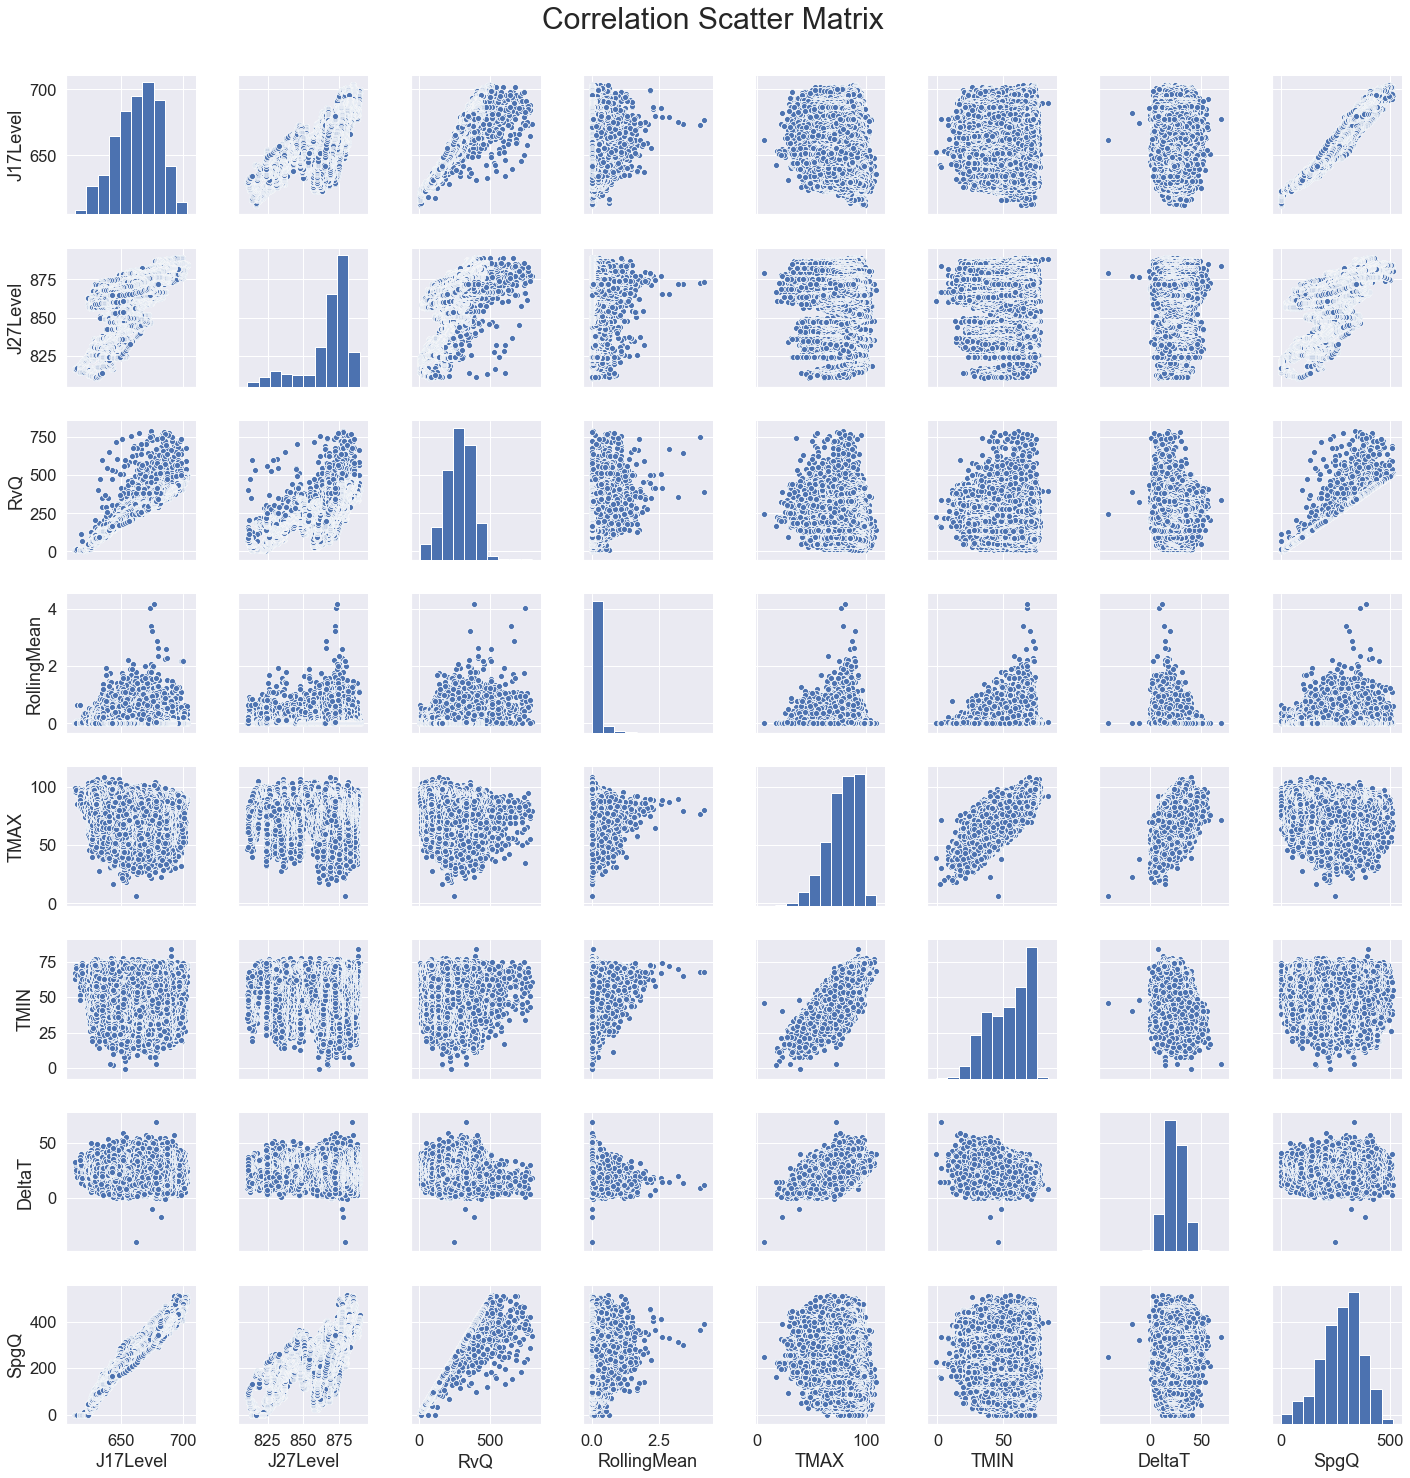

In [5]:
sns.set(font_scale=1.5) 
g = sns.pairplot(df, vars=df, markers='o')
g.fig.suptitle("Correlation Scatter Matrix", size=30, y=1.03)

In [6]:
correlation = df.corr().iloc[-1,:-1]
rank_correlation, rank_correlation_pval = stats.spearmanr(df) 
rank_correlation = rank_correlation[:,-1][:-1]
rank_correlation_pval = rank_correlation_pval[:,-1][:-1]
partial_correlation = partial_corr(df) 
partial_correlation = partial_correlation[:,-1][:-1]
rank_correlation_scatter, rank_correlation_pval = stats.spearmanr(df) 

/Users/emilypease/anaconda3/envs/geoenv/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/emilypease/anaconda3/envs/geoenv/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


### Pearson's Correlation, Spearman Rank Correlation, and Partial Correlation Coefficients

**Pearson's Correlation**: The Pearson correlation coefficient (Pearson's r) quantifies the linear relationsip between two features.  

**Spearman Rank Correlation**: The Spearman rank correlation coefficient ($\rho$) is similar to the Pearson correlation coefficient, but is more robust to outliers.  Notice that the Pearson's r for Q$_{riv}$ is very similar to the Spearman rank coefficient.  However, if the RvQ truncation is commented out, there will exist a significant difference in Q$_{riv}$ between the Pearson correlation and Rank correlation below due to the outliers.  

**Partial Correlation**: The partial correlation coefficient quantifies the usefulness of a feature in predicting the response when the impact of other precictor features is removed.  It is unexpected to find that index well J-27 is indeed negatively correlated with springflow discharge when the impact of other features is removed.  When examining the scatter matrix (above) between J-27 and springflow, they exhibit a strong positive linear correlation.

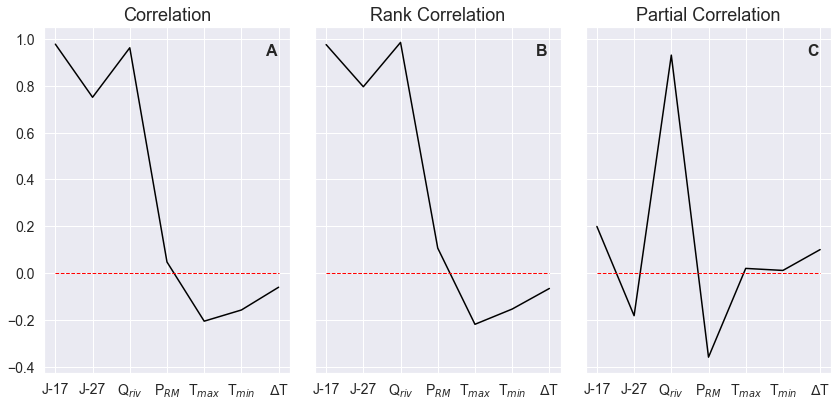

In [7]:
fig, axes = plt.subplots(1,3, figsize=(12,6), sharey=True)
features = df.columns.values[:-1]
labels = ['J-17', 'J-27', 'Q$_{riv}$', 'P$_{RM}$', r'T$_{max}$', r'T$_{min}$', r'$\Delta$T']

axes[0].set_xticklabels(labels);axes[1].set_xticklabels(labels);axes[2].set_xticklabels(labels)

axes[0].plot(features,correlation,color='black')
axes[0].plot([0,0,0,0,0,0,0],'r--',color='red',linewidth = 1.0);axes[0].set_title('Correlation')

axes[1].plot(features,rank_correlation,color='black')
axes[1].plot([0,0,0,0,0,0,0],'r--',color='red',linewidth = 1.0);axes[1].set_title('Rank Correlation')

axes[2].plot(features,partial_correlation,color='black')
axes[2].plot([0,0,0,0,0,0,0],'r--',color='red',linewidth = 1.0);axes[2].set_title('Partial Correlation')

axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=14)

axes[0].text(5.65, 0.98, 'A', fontsize=16, fontweight='bold', va='top')
axes[1].text(5.65, 0.98, 'B', fontsize=16, fontweight='bold', va='top')
axes[2].text(5.65, 0.98, 'C', fontsize=16, fontweight='bold', va='top')

fig.tight_layout()

(8, 0)

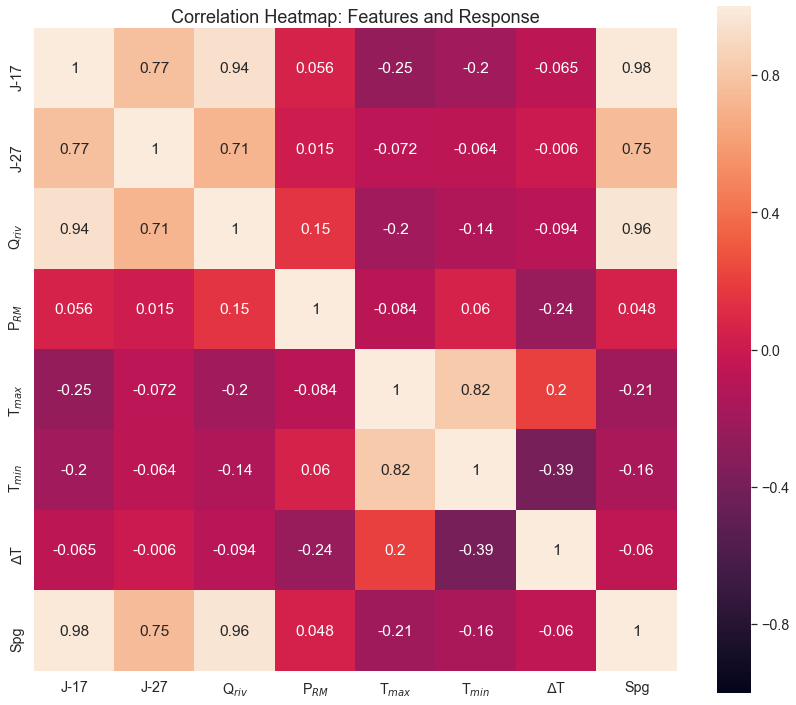

In [8]:
sns.set(font_scale=1.3) 
plt.figure(figsize=(12,10))

xticks = ["J-17", "J-27", "Q$_{riv}$", "P$_{RM}$", r"T$_{max}$", r"T$_{min}$", r"$\Delta$T", "Spg"]
yticks = ["J-17", "J-27", "Q$_{riv}$", "P$_{RM}$", r"T$_{max}$", r"T$_{min}$", r"$\Delta$T", "Spg"]

sns.heatmap(df.corr(), annot=True, linewidth=0, vmin=-1, square=True, xticklabels=xticks, yticklabels=yticks)
plt.title("Correlation Heatmap: Features and Response", size=18)
plt.tight_layout()
plt.ylim([8,0])

(8, 0)

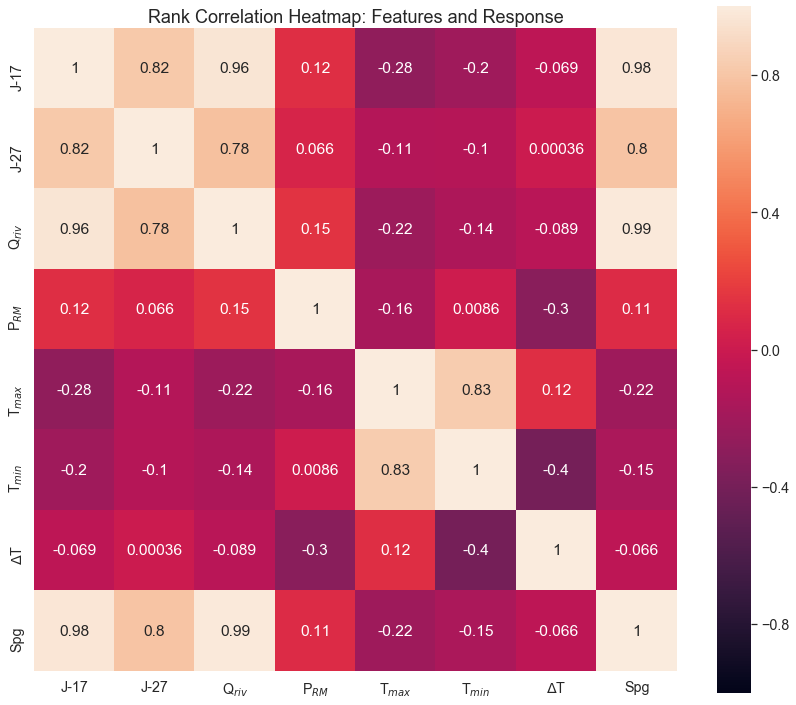

In [9]:
sns.set(font_scale=1.3) 
plt.figure(figsize=(12,10))

xticks = ["J-17", "J-27", "Q$_{riv}$", "P$_{RM}$", r"T$_{max}$", r"T$_{min}$", r"$\Delta$T", "Spg"]
yticks = ["J-17", "J-27", "Q$_{riv}$", "P$_{RM}$", r"T$_{max}$", r"T$_{min}$", r"$\Delta$T", "Spg"]

sns.heatmap(rank_correlation_scatter, annot=True, linewidth=0, vmin=-1, square=True, 
            xticklabels=xticks, yticklabels=yticks)
plt.title("Rank Correlation Heatmap: Features and Response", size=18)
plt.tight_layout()
plt.ylim([8, 0])

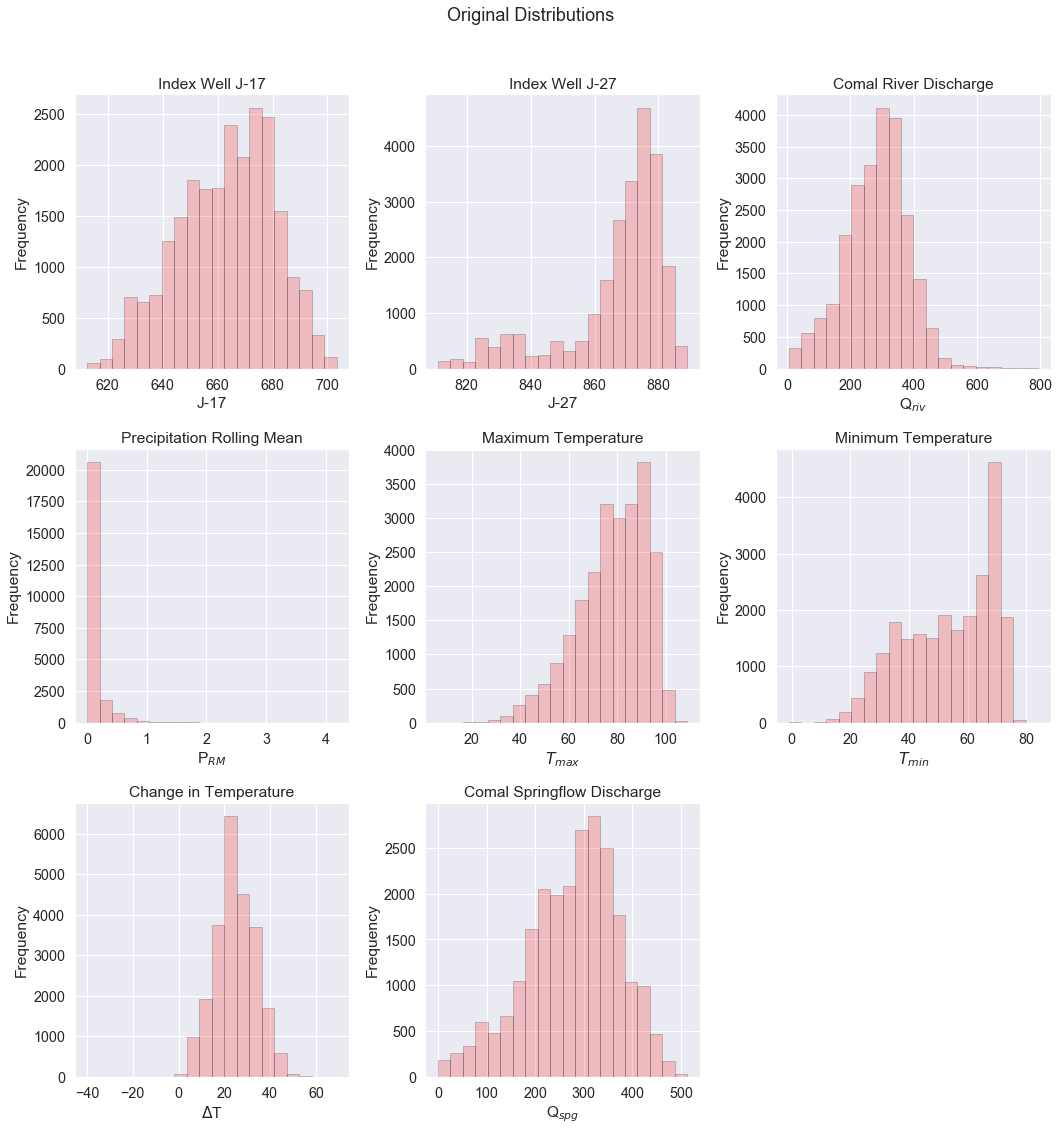

In [10]:
histograms(df, "Histograms_OriginalData.png", title='Original Distributions') 

### LASSO Model-Based Feature Selection

##### First, all predictor and response features must be standardized ($\sigma$=1, mean=0).  

The summary statistics are examined to ensure the data were properly transformed.

In [11]:
scaler = StandardScaler()                                   
sfeatures = scaler.fit_transform(df.values)             
df_st = pd.DataFrame(sfeatures, index=df.index, columns=df.columns) 
df_st.describe().T                                               

,count,mean,std,min,25%,50%,75%,max
J17Level,23806.0,-5.425029e-15,1.000021,-2.905797,-0.698068,0.091501,0.760566,2.308892
J27Level,23806.0,-5.902585e-15,1.000021,-3.450373,-0.202112,0.330542,0.643206,1.358901
RvQ,23806.0,-2.674310e-16,1.000021,-2.763577,-0.633383,0.088376,0.659769,5.130669
RollingMean,23806.0,-6.924553e-17,1.000021,-0.433127,-0.433127,-0.416514,-0.056562,20.399749
TMAX,23806.0,-4.250243e-16,1.000021,-5.048767,-0.638055,0.132069,0.832182,2.162396
TMIN,23806.0,-2.244510e-16,1.000021,-3.579361,-0.820514,0.164788,0.887343,2.004020
DeltaT,23806.0,8.357219e-17,1.000021,-7.288593,-0.634126,-0.070188,0.719325,5.005253
SpgQ,23806.0,-5.253109e-16,1.000021,-2.919868,-0.647224,0.145559,0.726933,2.502767


##### Next, a train test split is performed and the LASSO model is run.

Number of training data = 17854 and number of testing data = 5952


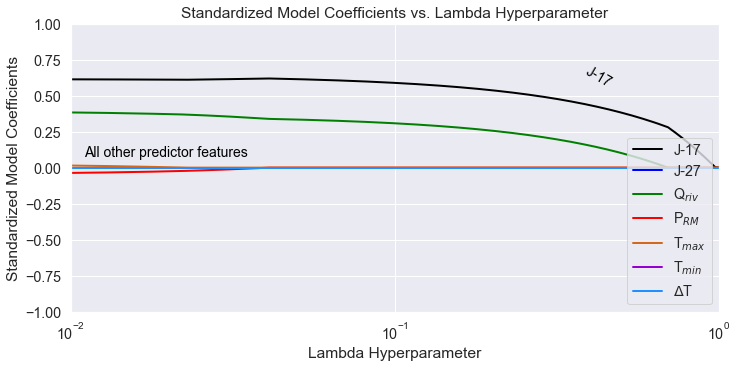

In [12]:
X = df_st.iloc[:, :-1].values
y = df_st.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=73073)
print('Number of training data = ' + str(len(X_train)) + ' and number of testing data = ' + str(len(X_test)))

nbins = 1000                                             
lams = np.linspace(0.001, 1.0, nbins)                     
coefs = np.ndarray((nbins, 7))
index = 0
for lam in lams:
    lasso_reg = Lasso(alpha=lam)                           
    lasso_reg.fit(X_train, y_train)                      
    coefs[index,:] = lasso_reg.coef_                       
    index = index + 1
    
color = ['black','blue','green',       'red',       'chocolate', 'darkviolet',  'dodgerblue']
label = ['J-17', 'J-27', r'Q$_{riv}$', 'P$_{RM}$',  'T$_{max}$', 'T$_{min}$',   '$\Delta$T']

plt.subplot(111)                                            
for ifeature in range(0,7):
    plt.semilogx(lams,coefs[:,ifeature], label=label[ifeature], c=color[ifeature], linewidth=2.0)
    
plt.text(0.38, .56, "J-17", fontsize=14, color='black', ha='left', rotation=-30) 
plt.text(0.011, .08, "All other predictor features", fontsize=14, color='black', ha='left', rotation=0) 

plt.title('Standardized Model Coefficients vs. Lambda Hyperparameter'); 
plt.xlabel('Lambda Hyperparameter'); plt.ylabel('Standardized Model Coefficients')
plt.xlim(0.01,1); plt.ylim(-1, 1);  plt.legend(loc = 'lower right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1., wspace=0.2, hspace=0.2)

Number of training data = 17854 and number of testing data = 5952


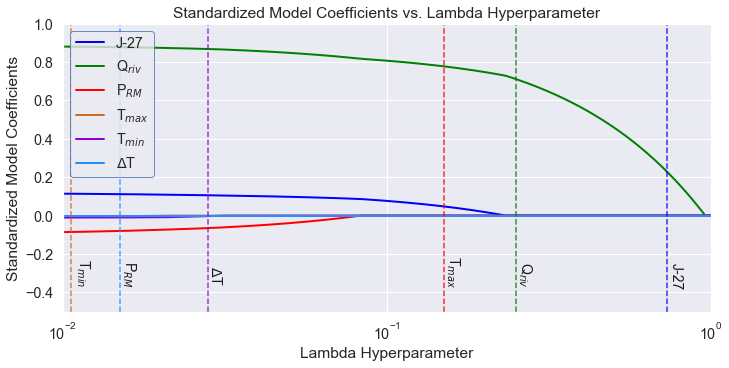

In [13]:
X = df_st.iloc[:, 1:-1].values
y = df_st.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=73073)
print('Number of training data = ' + str(len(X_train)) + ' and number of testing data = ' + str(len(X_test)))

nbins = 1000                                              
lams = np.linspace(0.001, 1.0, nbins)                        
coefs = np.ndarray((nbins, 6))
index = 0
for lam in lams:
    lasso_reg = Lasso(alpha=lam)                           
    lasso_reg.fit(X_train, y_train)                         
    coefs[index,:] = lasso_reg.coef_                        
    index = index + 1
    
color = ['blue','green',       'red',       'chocolate', 'darkviolet', 'dodgerblue']
label = ['J-27', r'Q$_{riv}$', 'P$_{RM}$', 'T$_{max}$', 'T$_{min}$', '$\Delta$T',  ]

plt.subplot(111)                                            
for ifeature in range(0,6):
    plt.semilogx(lams,coefs[:,ifeature], label=label[ifeature], c=color[ifeature], linewidth=2.0)

plt.axvline(x=0.015, color='dodgerblue', linestyle='--', alpha=0.8)
plt.axvline(x=0.028, color='darkviolet', linestyle='--', alpha=0.8)
plt.axvline(x=0.15, color='red', linestyle='--', alpha=0.8)
plt.axvline(x=0.25, color='green', linestyle='--', alpha=0.8)
plt.axvline(x=0.73, color='blue', linestyle='--', alpha=0.8)
plt.axvline(x=0.0106, color='chocolate', linestyle='--', alpha=0.8)

plt.title('Standardized Model Coefficients vs. Lambda Hyperparameter'); 
plt.xlabel('Lambda Hyperparameter'); 
plt.ylabel('Standardized Model Coefficients')
plt.xlim(0.01,1); plt.ylim(-0.5, 1);  
# plt.ylim(-0.01, 0.01)

plt.text(0.74, -.37, "J-27", fontsize=14, color='k', ha='left', rotation=270) 
plt.text(0.25, -.35, "Q$_{riv}$", fontsize=14, color='k', ha='left', rotation=270) 
plt.text(0.15, -.35, r"T$_{max}$", color='k', fontsize=14, ha='left', rotation=270) 
plt.text(0.028, -.35, r"$\Delta$T", fontsize=14, color='k', ha='left', rotation=270) 
plt.text(0.0108, -.35, r"T$_{min}$", fontsize=14, color='k', ha='left', rotation=270) 
plt.text(0.015, -.35, r"P$_{RM}$", fontsize=14, color='k', ha='left', rotation=270) 

leg = plt.legend();leg.get_frame().set_edgecolor('b')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1., wspace=0.2, hspace=0.2)